# Função de Rastrigin

Primeiramente, como uma introdução para a atividade, a função Rastrigin foi implementada para um domínio bidimensional e plotada.

In [17]:
import sys
sys.path.insert(0, 'C:/Python37/Lib/site-packages')
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

## Implementação da Função de Rastrigin 2D

In [5]:
def rastrigin(x,y):
    return 20 + x**2 + y**2 - 10 * (np.cos(2*np.pi*x) + np.cos(2*np.pi*y)) # Considerando A=10

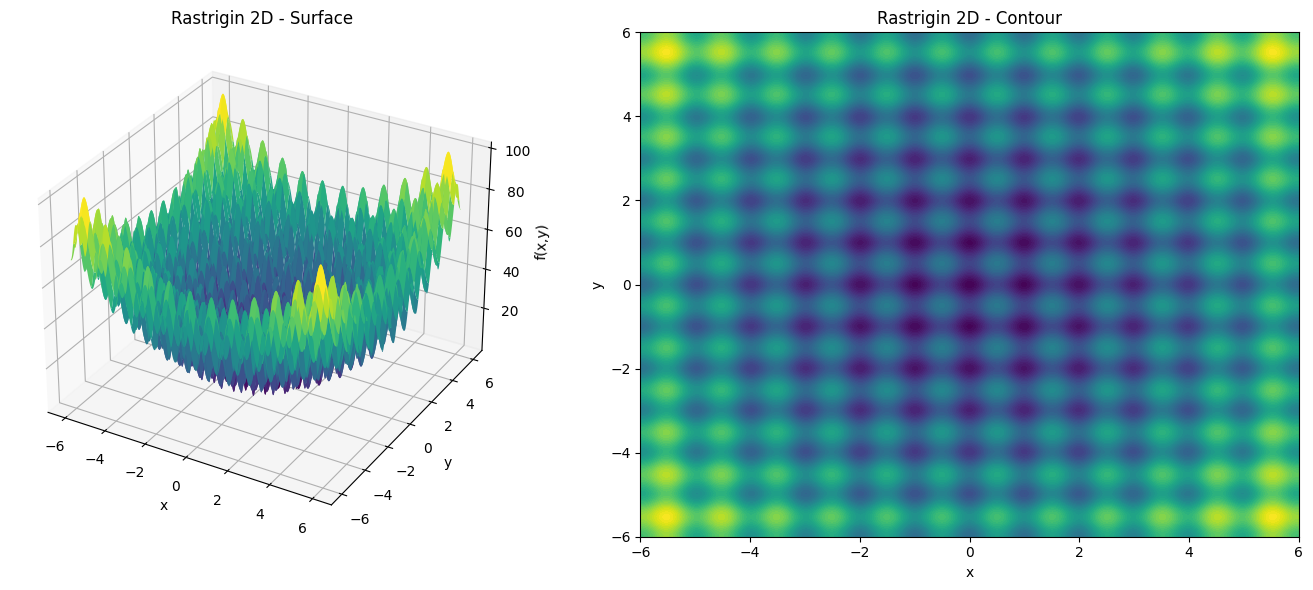

In [9]:
x = np.linspace(-6,6,500)
y = np.linspace(-6,6,500)
X, Y = np.meshgrid(x, y)
Z = rastrigin(X, Y)

fig = plt.figure(figsize=(14, 6))

# 3D plot:
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.plot_surface(X,Y,Z, cmap='viridis')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('f(x,y)')
ax1.set_title('Rastrigin 2D - Surface')

#Contour
ax2 = fig.add_subplot(1,2,2)
ax2.contourf(X,Y,Z, levels=50, cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Rastrigin 2D - Contour')


plt.tight_layout()
plt.show()

## Implementação da Função de Rastrigin Genérica

In [12]:
def rastrigin_n(x):
    x=np.asarray(x)
    n=len(x)
    return 10*n + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))   

In [19]:
# Testando mínimo global apresentado na descrição do trabalho:
rastrigin_n(np.zeros(10))

0.0

## Implementação do Algoritmo Genérico

In [63]:
class GeneticAlgorithmRastrigin:
    def __init__(self, n=10, pop_size=100, bits_per_var=10, generations=10**5, Pc=0.9,
               Pm=0.03, tournament_size=3, var_min=-5.12, var_max=5.12, elitism=True):
        self.n = n
        self.pop_size = pop_size
        self.bits_per_var = bits_per_var
        self.generations = generations
        self.mutation_rate = Pm
        self.crossover_rate = Pc
        self.tournament_size = tournament_size
        self.var_min = var_min
        self.var_max = var_max
        self.population = self.init_population()
        self.best_fitness_history = []
        self.avg_fitness_history = []
        self.best_individual = None
        self.best_fitness = float('inf')
        self.elitism = elitism

    def decode(self, individual):
        vars = []
        for dimension in range(self.n):
            bits = individual[dimension*self.bits_per_var : (dimension+1)*self.bits_per_var]
            integer = int(''.join(str(b) for b in bits), 2)
            value = self.var_min + (self.var_max - self.var_min) * integer / (2**self.bits_per_var - 1)
            vars.append(value)
        return np.array(vars)

    def evaluate(self):
        fitness = np.zeros(self.pop_size)
        for index, ind in enumerate(self.population):
            fitness[index] = rastrigin_n(self.decode(ind)) 
        return fitness

    def roulette_selection(self, fitness):
        inverse_fitness = 1 / (1 + fitness)
        total_fit = np.sum(inverse_fitness)
        pick = random.uniform(0, total_fit)
        current = 0
        for index, fit in enumerate(inverse_fitness):
            current += fit
            if current >= pick:
                return self.population[index]

    def tournament_selection(self, fitness):
        candidates = random.sample(list(zip(self.population, fitness)), self.tournament_size)
        winner = min(candidates, key=lambda x: x[1])
        return winner[0]

    def crossover(self, parent1, parent2):
        if random.random() > self.crossover_rate:
            return parent1, parent2
        child1, child2 = [], []
        for i in range(self.n):
            start = i * self.bits_per_var
            end = (i + 1) * self.bits_per_var
            point = random.randint(1, self.bits_per_var - 1)
            c1 = parent1[start:start+point] + parent2[start+point:end]
            c2 = parent2[start:start+point] + parent1[start+point:end]
            child1.extend(c1)
            child2.extend(c2)
        return child1, child2

    def mutate(self, individual):
        idx = random.randint(0, self.n * self.bits_per_var - 1)
        individual[idx] = 1 - individual[idx]

    # Inicializa uma população onde cada indivíduo tem tamanho de self.n * self.bits_per_var
    def init_population(self):
        return [[random.randint(0, 1) for _ in range(self.n * self.bits_per_var)] for _ in range(self.pop_size)]

    def fit(self):
        for gen in range(self.generations):
            # Avaliação: 
            fitness = self.evaluate()
            index = np.argmin(fitness)
            if fitness[index] < self.best_fitness:
                self.best_fitness = fitness[index]
                self.best_individual = self.population[index]
            self.best_fitness_history.append(self.best_fitness)
            self.avg_fitness_history.append(np.mean(fitness))
            
            new_population = []
            if self.elitism:
                new_population.append(self.best_individual)
            while len(new_population) < self.pop_size:
                # Seleção: 50% roleta, 50% torneio
                if random.random() < 0.5:
                    p1 = self.roulette_selection(fitness)
                    p2 = self.roulette_selection(fitness)
                else:
                    p1 = self.tournament_selection(fitness)
                    p2 = self.tournament_selection(fitness)
                
                # Cross-over
                c1, c2 = self.crossover(p1, p2)

                # Aplicando Mutação 
                if random.random() < self.mutation_rate:
                    self.mutate(c1)
                if random.random() < self.mutation_rate:
                    self.mutate(c2)

                # Gerando nova população, sempre com o tamanho pop size
                new_population.append(c1)
                if len(new_population) < self.pop_size:
                    new_population.append(c2)

            self.population = new_population
            if gen%1000 == 0:
                print(f"Geração {gen+1} | Melhor Fitness: {self.best_fitness:.5f}")

        print("\nMelhor solução encontrada:")
        print("x =", self.decode(self. best_individual))
        print("f(x) =", self.best_fitness)

## Aplicação do Algoritmo Genético ao Problema

In [64]:
ga = GeneticAlgorithmRastrigin()
ga.fit()

Geração 1 | Melhor Fitness: 104.74872
Geração 1001 | Melhor Fitness: 3.31978
Geração 2001 | Melhor Fitness: 3.31978
Geração 3001 | Melhor Fitness: 3.31978
Geração 4001 | Melhor Fitness: 3.31978
Geração 5001 | Melhor Fitness: 3.31978
Geração 6001 | Melhor Fitness: 3.31978
Geração 7001 | Melhor Fitness: 3.31978
Geração 8001 | Melhor Fitness: 3.31978
Geração 9001 | Melhor Fitness: 3.31978
Geração 10001 | Melhor Fitness: 3.31978
Geração 11001 | Melhor Fitness: 3.31978
Geração 12001 | Melhor Fitness: 3.31978
Geração 13001 | Melhor Fitness: 3.31978
Geração 14001 | Melhor Fitness: 2.32959
Geração 15001 | Melhor Fitness: 2.32959
Geração 16001 | Melhor Fitness: 2.32959
Geração 17001 | Melhor Fitness: 2.32959
Geração 18001 | Melhor Fitness: 2.32959
Geração 19001 | Melhor Fitness: 2.32959
Geração 20001 | Melhor Fitness: 2.32959
Geração 21001 | Melhor Fitness: 2.32959
Geração 22001 | Melhor Fitness: 2.32959
Geração 23001 | Melhor Fitness: 2.32959
Geração 24001 | Melhor Fitness: 2.32959
Geração 250

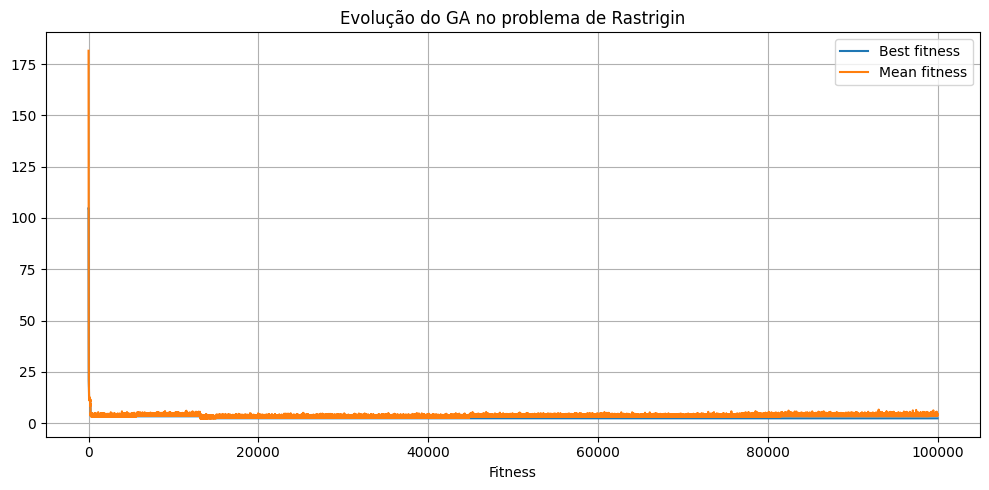

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(ga.best_fitness_history, label="Best fitness")
plt.plot(ga.avg_fitness_history, label="Mean fitness")
plt.xlabel("Geração")
plt.xlabel("Fitness")
plt.title("Evolução do GA no problema de Rastrigin")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()